In [2]:
import numpy as np
%pylab
%matplotlib inline

from Functions import functions as f
import skimage.io as sk
from collections import Counter


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [20]:
img = sk.imread("Data/N2DH-GOWT1/img/t01.tif") #Bild laden
#f.show_image(img, 15, 8)


C:\Users\marie\anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [4]:

def seeds(img, T1, T2): # automatic seed selection algorithm
    result = np.zeros(img.shape)
    sd_seeds = f.standarddeviation(img,3) # standard deviation
    sd_flat = sd_seeds.flatten() # standard deviation as 1D-array
    similarity_seeds = 1 - sd_seeds/max(sd_flat) # calculates similarity of every pixel to its neighbors
    eurel_seeds = f.euclidean_relative(img, 3) # relative euclidean distance of every pixel to its neighbors
    for p in np.ndindex(img.shape): # border pixel value is zero
        if similarity_seeds[p] > T1 and eurel_seeds[p] < T2: # compares pixel with threshold
            result[p] = 1 # assigns value 1 to seeds
    return result

#Achtung auch Randpixel bekommen Wert 1 und sind somit immer seeds! In seed_merging werden diese jedoch wieder als seeds entfernt.
#Fehler Testbild, keine Seeds im Hintergrund gefunden, überprüfen!


#seed_final = seeds(img, 0.4, 40)
#f.show_image(seed_final, 15, 8)



In [5]:
def seed_merging(img):
    regions = np.zeros(img.shape) #creates new array for region numbers for every image pixel
    count = 1 #keep track of region number
    for p in np.ndindex(img.shape): #iterates over every pixel of the image
        if img[p] == 1: #tests if pixel is seed
            if p[0]-1 >= 0 and p[1]-1 >= 0 and p[0]+1 <= img.shape[0] -1 and p[1]+1 <= img.shape[1] -1: # no calculation of border pixels
                for q in np.ndindex(3, 3): # iterates over 3x3 neighborhood
                    i = p[0]-1 + q[0]
                    j = p[1]-1 + q[1]
                    if regions[i,j] != 0: #tests if neighbors are also seeds
                        regions[p] = regions[i,j] # merge neighboring seeds; wird zur letzten abgefragten Region zugeordnet
                if regions[p] == 0: #tests if no neighbors are seeds
                    regions[p] = count #creates new region from new seed
                    count += 1
    return regions

#test = seed_merging(seeds(f.img_resize(img, 500, 500), 0.4, 40))
#print(test)

In [6]:
#reduce number of starting regions for region growing by only considering starting regions with more than T seeds
def decrease_region_number(img, T):
    list = Counter(img.flatten()) #counts number of seeds in region
    d_seeds = img.copy() 
    for i in range(1, int(np.amax(img))): #iterates over every region
        if list[i] <= T:#if number of seeds is smaller than threshold, delete region
            for p in np.ndindex(img.shape):
                if img[p] == i:
                    d_seeds[p] = 0
    return d_seeds

#test2 = decrease_region_number(test, 10)
#f.show_image(test2, 15, 8)

In [7]:
#test3 = decrease_region_number(test, 50)
#f.show_image(test3, 15, 8)

In [8]:
def find_neighbors(regions):
    Ne = []
    for p in np.ndindex(regions.shape):
        if regions[p] != 0: # Pixels with region
            if p[0] > 0: # Add neighbours to list T, left
                a = (p[0]-1, p[1])
                if regions[a] == 0 and a not in Ne:
                    Ne.append(a)
            if p[0] < regions.shape[0]-1: # Add neighbours to list T, right
                b = (p[0]+1, p[1])
                if regions[b] == 0 and b not in Ne:
                    Ne.append(b)
            if p[1] > 0: # Add neighbours to list T, up
                c = (p[0], p[1]-1)
                if regions[c] == 0 and c not in Ne:
                    Ne.append(c)
            if p[1] < regions.shape[1]-1: # Add neighbours to list T, down
                d = (p[0], p[1]+1)
                if regions[d] == 0 and d not in Ne:
                    Ne.append(d)
    return Ne

In [9]:
#neighbors = find_neighbors(test3)
#print(neighbors)

In [10]:
def add_neighbors(img, p): #p describes pixel for which neighbors need to be added
    Ne1 = []
    if p[0] > 0: # Add neighbours to list T, up
        a = (p[0]-1, p[1])
        Ne1.append(a)
    if p[0] < img.shape[0]-1: # Add neighbours to list T, down
        b = (p[0]+1, p[1])
        Ne1.append(b)
    if p[1] > 0: # Add neighbours to list T, left
        c = (p[0], p[1]-1)
        Ne1.append(c)
    if p[1] < img.shape[1]-1: # Add neighbours to list T, right
        d = (p[0], p[1]+1)
        Ne1.append(d)
    return Ne1  #returns list of all existing direct neighbors (maximum 4 pixels)

In [11]:
def mean_region(img, regions): #img is array of intensity values, regions is array with region numbers
    mean = []
    region_max = int(max(regions.flatten())) #calculates amount of regions
    for count in range(1,region_max + 1): # iterates over every region
        intensity = []
        for p in np.ndindex(img.shape):
            if regions[p] == count:
                intensity.append(img[p]) #iterates over every pixel in the image and appends intensity value, if it is in the region
        mean.append(sum(intensity)/len(intensity)) #calculates mean value of region
    return mean #returns list with average of every region

In [12]:
# calculated mean value of region of newly labeled pixel
def one_region_mean(img, regions, new_pixel): #img is array of intensity values, regions is array with region numbers, new_pixel is position of last added pixel
    intensity = []
    for p in np.ndindex(img.shape):
        if regions[p] == regions[new_pixel]: # finds region of newly added pixel
            intensity.append(img[p]) #iterates over every pixel in the image and appends intensity value, if it is in the region
    single_mean = sum(intensity)/len(intensity) #calculates mean value of region with new pixel
    return single_mean #returns mean value of changed region

In [13]:
def calculation_distance(img, Ne, regions): # img intensity values, regions is region number, Ne is list of neighbours
    max_intensity = np.amax(img)
    means = mean_region(img, regions) # list of mean values of every region
    result = np.ones(img.shape) # new array with distance values, standard value is one
    nearest_reg = np.zeros(img.shape)
    for i in Ne:
        nei = add_neighbors(img, i) # list 4 neighbors of pixel i out of unsorted neighbors list
        distance = []
        region_number = []
        for j in nei:
            if regions[j] != 0: # only neighboring pixels which are sorted
                distance.append(np.abs((img[j] - means[int(regions[j]-1)])) / max_intensity) # saves tuple of normalized distance of pixel to neighbor j and region of j
                region_number.append(regions[j])
        min_dist = min(distance)  # saves minimal distance to 1 of its neighbors in distance array
        pos_min_dist = distance.index(min(distance))
        nearest_reg[i] = region_number[int(pos_min_dist)-1] # saves number of nearest region
        result[i] = min_dist
    return result, nearest_reg  # returns array with distance values between 0 and 1 and array with number of nearest region

In [14]:
#updates distances for updated region
def new_distance(img, regions, nearest_reg, distances, new_pixel, Ne):
    new_mean = one_region_mean(img, regions, new_pixel)
    means = mean_region(img, regions)
    means[int(regions[new_pixel] -1)] = new_mean # list of all mean values of the region with the updated region
    max_intensity = np.amax(img)
    for i in Ne:
        nei = add_neighbors(img, i) # list 4 neighbors of pixel i out of unsorted neighbors list
        distance = []
        region_number = []
        for j in nei:
            if regions[j] == regions[new_pixel]: # calculates distance only for pixel adjacent to updated region
                for k in nei:
                    if regions[k] != 0: # compare all neighboring regions
                        distance.append(np.abs((img[k] - means[int(regions[k]-1)])) / max_intensity) # saves tuple of normalized distance of pixel to neighbor j and region of j
                        region_number.append(regions[k])
                min_dist = min(distance)  # saves minimal distance to 1 of its neighbors in distance array
                # only calculates new distances once
                pos_min_dist = distance.index(min_dist)
                nearest_reg[i] = region_number[int(pos_min_dist)-1] # saves number of nearest region # saves number of nearest region
                distances[i] = min_dist
    return distances, nearest_reg  # returns array with distance values between 0 and 1 and array with number of nearest region



In [15]:
def label(regions, distances, nearest_reg, Ne): # regions is array of region numbers, distances is array of distances, nearest_reg is array of nearest region number
    x = np.where(distances == np.amin(distances)) #finds minimal distance in array and its position
    print(distances)
    pos_min_dist = list(zip(x[0], x[1]))[0] # position of first pixel with minimal distance value
    pos_min_dist = (int(pos_min_dist[0]), int(pos_min_dist[1])) #converting to int for finding in list
    regions[pos_min_dist] = nearest_reg[pos_min_dist]
    print(pos_min_dist)
    print(Ne)
    Ne.remove(pos_min_dist) #removes newly labeled entry from list Ne
    distances[pos_min_dist] = 1
    print(len(Ne))
    return regions, pos_min_dist, Ne, distances # returns new labeled region array and position of newly labeled pixel

In [16]:
def region_growing(img, regions):
    Ne = find_neighbors(regions) #list of all adjacent pixels
    dist = calculation_distance(img, Ne, regions) #array of smallest distances
    regions_new = label(regions, dist[0], dist[1], Ne) #labels pixel with smallest distance
    Ne = regions_new[2]
    distances = regions_new[3]
    Ne_add = add_neighbors(img, regions_new[1]) #finds neighbors of newly labeled pixel
    for j in Ne_add: #updates list of adjacent pixels
        if j not in Ne and regions[j] == 0:
            Ne.append(j)
    while len(Ne)>0: #as long as not all pixels are sorted
        dist = new_distance(img, regions_new[0], dist[1], distances, regions_new[1], Ne) #updates distances
        regions_new = label(regions_new[0], dist[0], dist[1], Ne) #labels next pixel
        Ne = regions_new[2]
        distances = regions_new[3]
        Ne_add = add_neighbors(img, regions_new[1]) #finds neighbors of newly labeled pixel
        for j in Ne_add: #updates Ne
            if j not in Ne and regions[j] == 0:
                Ne.append(j)
    return regions_new[0] #returns array with region numbers

C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\functions.py:54: RuntimeWarning: invalid value encountered in double_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\functions.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list


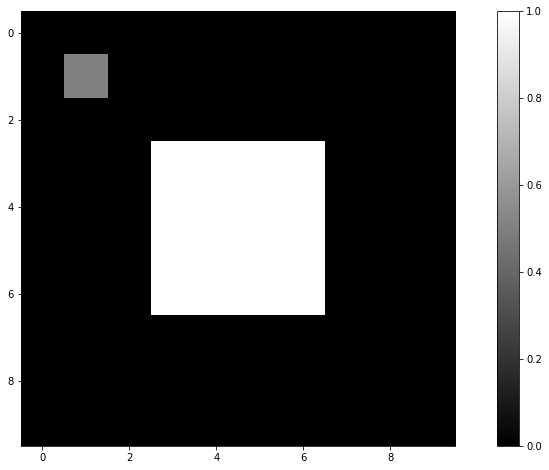

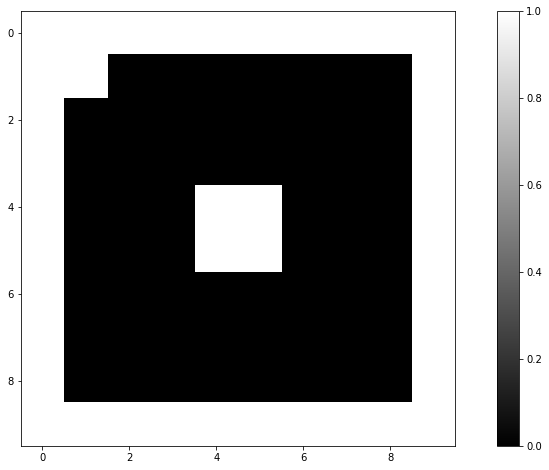

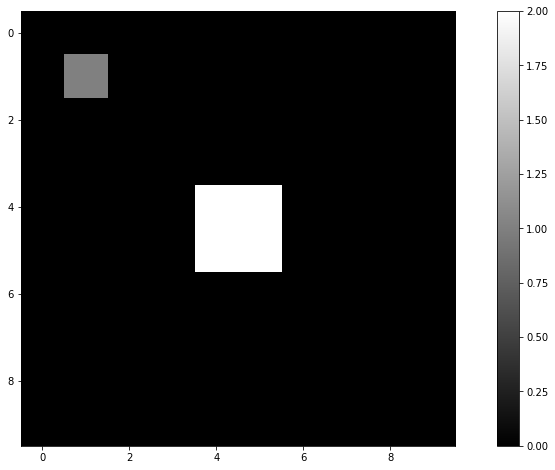

In [17]:
img_n = np.zeros([10, 10])
img_n[3:7, 3:7] = 1
img_n[1:2, 1:2] = 0.5
f.show_image(img_n,15,8)

img_t = seeds(img_n, 0.4, 40)
f.show_image(img_t,15,8)
img_t = seed_merging(img_t)
f.show_image(img_t,15,8)

[[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
(0, 1)
[(0, 1), (2, 1), (1, 0), (1, 2), (3, 4), (4, 3), (3, 5), (4, 6), (6, 4), (5, 3), (6, 5), (5, 6)]
11
[[0.25 1.   0.25 1.   1.   1.   1.   1.   1.   1.  ]
 [0.25 1.   0.25 1.   1.   1.   1.   1.   1.   1.  ]
 [1.   0.25 1.   1.   1.   1.   1.   1.   1.   1.  ]
 [1.   1.   1.   1.   0.   0.   1.   1.   1.   1.  ]
 [1.   1.   1.   0.   1.   1.   0.   1.   1.   1.  ]
 [1.   1.   1.   0.   1.   1.   0.   1.   1.   1.  ]
 [1.   1.   1.   1.   0.   0.   1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]]
(3, 4)
[(2, 1), (1, 0), (1, 2),

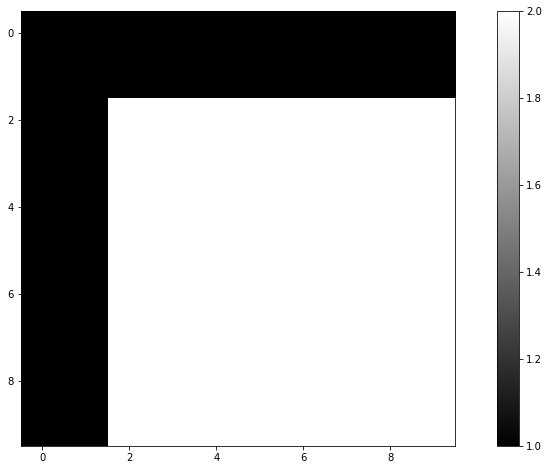

In [18]:
img_t = region_growing(img_n, img_t)
f.show_image(img_t, 15,8)

In [ ]:
img_small = img[300:400, 400:500]
f.show_image(img_small, 15, 8)
img_r = seeds(img_small, 0.4, 40)
f.show_image(img_r, 15, 8)
img_r = seed_merging(img_r)
f.show_image(img_r, 15, 8)
img_r = region_growing(img_small, img_r)
f.show_image(img_r, 15, 8)




    





C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\functions.py:54: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\functions.py:54: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\functions.py:54: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list


[[1. 1. 0. ... 1. 0. 1.]
 [1. 0. 1. ... 0. 1. 0.]
 [1. 1. 0. ... 1. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 1. 0. 1.]
 [1. 1. 0. ... 0. 1. 1.]]
(0, 2)
[(0, 2), (2, 2), (1, 1), (1, 3), (0, 4), (2, 4), (1, 5), (0, 19), (2, 19), (1, 18), (1, 20), (0, 21), (2, 21), (1, 22), (0, 24), (2, 24), (1, 23), (1, 25), (0, 26), (2, 26), (1, 27), (0, 37), (2, 37), (1, 36), (0, 38), (2, 38), (1, 39), (0, 41), (1, 40), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (2, 60), (0, 61), (2, 61), (0, 62), (2, 62), (1, 63), (0, 64), (1, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (1, 81), (0, 82), (1, 83), (0, 86), (1, 85), (0, 87), (0, 88), (1, 89), (0, 98), (2, 98), (1, 97), (1, 99), (1, 6), (3, 6), (2, 5), (2, 7), (1, 9), (3, 9), (2, 8), (2, 10), (1, 29), (3, 29), (2, 28), (2, 